# 0. 课程前言
此为 <<人工智能安全>> 课程第一部分: 对抗攻击实验部分.

# 引入必要的库

In [1]:
import os
import json
import numpy as np 
import matplotlib.pyplot as plt

# 进度条显示
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F 
import torch.utils.data as data

# Torchvision
import torchvision 
from torchvision import transforms 

# PyTorch Lighting
import pytorch_lightning as pl


# 前期准备

In [2]:
# 数据集安装位置
DATASET_PATH = "../data"
# 下载预训练模型的位置
CHECKPOINT_PATH = "../saved_models/tutorial10"

# 设置固定随机种子，提供可复现性
pl.seed_everything(42)

# CUDNN 是一个用于GPU加速库
torch.backends.cudnn.deterministic = True #设置True以使其在加速时选择固定的操作，使实验具有复现性
torch.backends.cudnn.benchmark = False #设置False以使其在加速时选择固定的操作，使实验具有复现性

# 获取训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))


Seed set to 42


In [3]:
# 获取数据集
import urllib.request
from urllib.error import HTTPError
import zipfile
# 数据集下载URL
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# 需要下载的文件
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# 创建对应文件夹以存储
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 下载文件
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}... ")
        try:
            # 从 file_url 下载文件到 file_path
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            # 下载失败
            print("Something went wrong. Please try to download the file again.")
        if file_name.endswith(".zip"):
            print("Unzipping file...") # 解压到当前目录
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/", 1)[0])

In [48]:
# Deep CNNs on ImageNet
# 使用普通的在ImageNet数据集上训练的CNN架构模型，可由 torchvision 包提供

# 设置环境变量TORCH_HOME ，PyTorch下载预训练模型、保存检查点等操作，会放在 TORCH_HOME 指定的目录
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device) # 把模型放到 device 中

pretrained_model.eval() # 设置模型为评估模式
for p in pretrained_model.parameters():
    p.requires_grad = False # 冻结模型参数，加速模型推理


In [49]:
# 定义图像预处理操作
NORM_MEAN = np.array([0.485, 0.465, 0.406])
NORM_STD  = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(), # 图像数据转为tensor张量，且像素值放缩到[0, 1]范围
    transforms.Normalize(mean=NORM_MEAN, # 图像数据归一化，转换为标准高斯分布 -> mean=0, std=1
                         std=NORM_STD)
])

# 载入数据集
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"could not fine the ImageNet dataset at '\{imagenet_path}'"
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# 创建数据迭代器，每次从迭代器中取 batch_size 个样本进行训练或推理
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# 加载标签
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

# 返回 label_name 对应索引
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label '{lab_str}' not found."
    return label_names.index(lab_str)

In [50]:
# 测试模型，使用 top-k 方法来评估模型性能
def eval_model(dataset_loader, img_func=None):
    # img_func 对图像应用某种变换
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(data_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs) # 获取预测概率向量
        tp += (preds.argmax(dim=-1) == labels).sum() # 概率最大的为labels，即预测正确的数量
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[..., None]).any(dim=-1).sum() # top-5 预测成功数
        counter += preds.shape[0] # 评估的样本总数
    acc = tp.float().item() / counter
    top5 = tp_5.float().item() / counter
    print(f"Top-1 error: {(100.0 * (1 -  acc)): 4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)): 4.2f}%")
    return acc, top5
        

In [7]:
_ = eval_model(dataset_loader=data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error:  19.50%
Top-5 error:  4.40%


In [51]:
# 图形化展示预测概率向量
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None, norm=True):
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        if norm is True:
            img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None] # 反归一化
        img = np.clip(img, a_min=0.0, a_max=1.0) # 像素值裁剪到 [0., 1.] 范围
        label = label.item()

    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        if norm is True:
            adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')

        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')

        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()
    

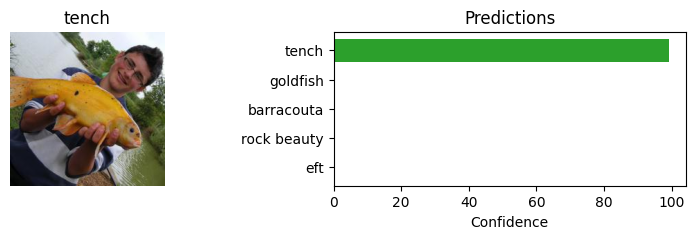

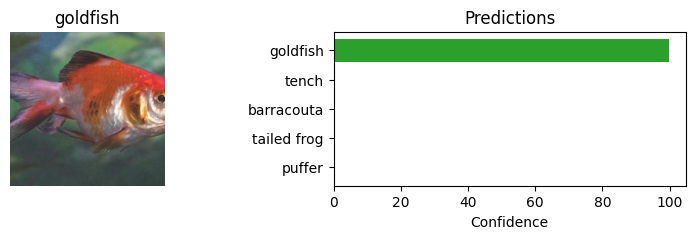

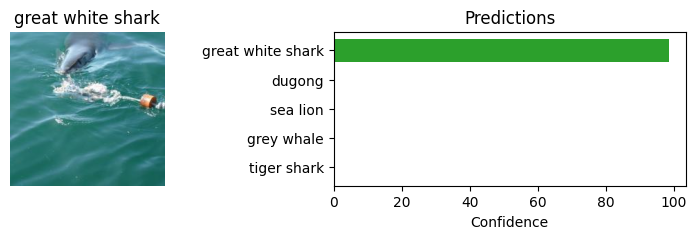

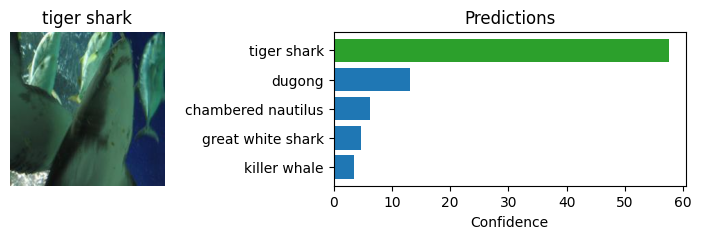

In [52]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

# 对抗攻击1. FGSM
设 $x$ 为输入样本，$y$ 为 $x$ 对应的标签，$\theta$ 为深度学习模型的参数。

深度学习模型通过拟合这样一个函数 $f(x; \theta) = y$ 来学习输入特征 $x$ 与输出标签 $y$ 的映射关系，其训练目标是最小化损失函数 $\mathcal L(f(x; \theta), y)$ ，损失函数值越小，对应的预测 $f(x; \theta)$ 与 $x$ 的真实标签 $y$ 越接近。

**快速梯度符号法(Fast gradient Sign Method, FGSM)** 的对抗攻击思想则反其道而行之，通过构造对抗样本 $x_{adv} = x + \delta$ ($\delta$ 为添加的噪声)使得 $x_{adv}$ 相对于 $x$ ，其在损失函数 $\mathcal{L} (f(x_{adv}; \theta), y)$ 上的值尽可能最大化，这样就破坏了模型的预测可靠性。

如何定义 $\delta$ 使其对抗样本 $x_{adv}$ 损失函数值最大化？由于模型在 $x$ 处的损失函数梯度 $\nabla_x \mathcal L(f(x; \theta), y)$ 指示了其损失下降最快的方向。因此，若要最大化损失，对抗扰动 $\delta$ 的方向应沿着梯度的正方向（即梯度上升方向）。

> Q: 反向传播过程对 $\theta$ 求导，以便使用SGD更新参数，即 $\nabla_\theta \mathcal L$ 为梯度下降最快方向。为什么FGSM 使用 $\nabla_x \mathcal L$ 作为梯度下降最快的方向？ \
> A: 对抗样本 $x_{adv}$ 的 "最大化损失函数" 是相对于 $x$ 而言的，即在 $x$ 的基础上最大化。模型为冻结的预训练模型，因此此时模型 $f(x; \theta)$ 的变量只有 $x$ ，$\theta$ 为常量。（$\theta$ 在训练过程才需要更新）

因此，定义对抗扰动

$$
\delta = \epsilon \cdot sign(\nabla_x \mathcal L (f(x; \theta), y))
$$

其中 $\epsilon$ 是扰动强度的超参数；$sign$ 表示符号函数，确保扰动方向与梯度方向一致。

由对抗扰动公式可以看出，FGSM属于**白盒攻击**，需要访问模型参数 $\theta$ 和梯度信息。为保证对抗样本的不可察觉性，扰动 $\delta$ 需满足 $|| \delta ||_\infty \le \epsilon$ ，即每个像素的扰动幅度不超过 $\epsilon$ （通常取较小值，如 $\epsilon$ = 0.1）。

综上所述, 可将FGSM算法流程概括为:
1. 计算模型在给定样本 $(x, y)$ 上的损失函数 $\mathcal L(f(x; \theta), y)$
2. 计算模型损失函数的梯度 $\nabla_x \mathcal L(f(x; \theta), y)$
3. 计算对抗扰动 $\delta$
4. 由对抗扰动计算得到对抗样本 $ x_{adv}$

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    '''
    FGSM 对抗样本生成函数

    参数:
        model (nn.Module): 目标模型(应处于评估模式)
        imgs (Tensor, device=cpu): 一个 epoch 的图像, 来自原始数据集
        labels (Tensor, device=cpu): 图像的真实标签
        epsilon (float): 扰动系数, 默认 0.02
    '''

    # TODO: 完成FGSM算法


    
    # 示例占位代码，需替换
    fake_imgs = imgs.clone() # 生成的对抗样本
    delta = torch.zeros_like(imgs) # 实际扰动
    
    return fake_imgs, delta # 需位于 cpu

SyntaxError: invalid syntax (1192288514.py, line 5)

接下来我们评估对抗样本在预训练模型上的表现:

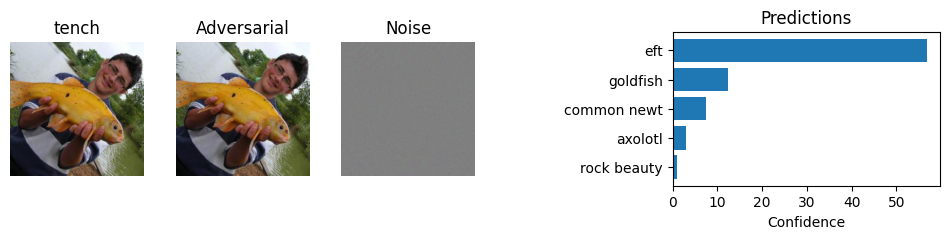

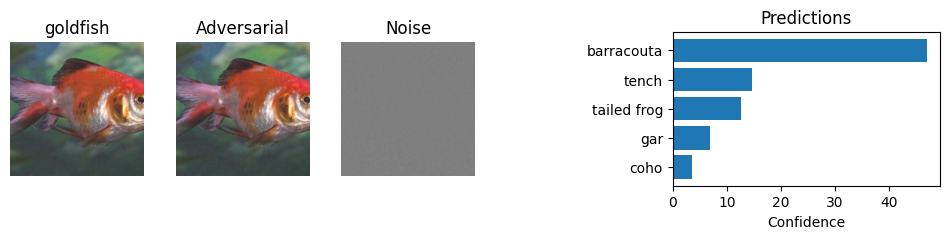

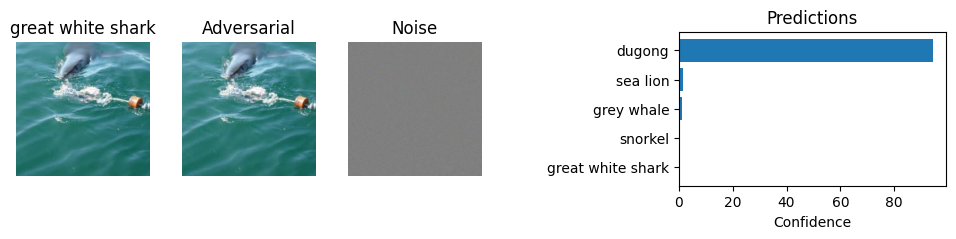

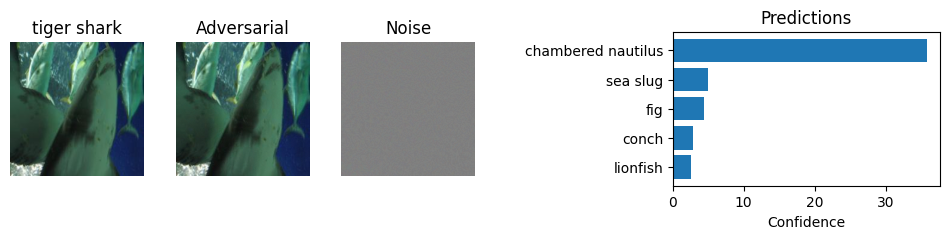

In [ ]:
adv_imgs, noise = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)

with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

预训练模型在对抗样本上的预测准确率:

In [55]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error:  93.74%
Top-5 error:  60.78%


# 对抗攻击2. PGD
**投影梯度下降(Project Gradient Descent, PGD)** 是一种通过迭代优化扰动方向，生成对抗样本的攻击方法。它通过多次梯度上升迭代，逐步逼近损失函数的局部最大值，从而生成更具攻击性的对抗样本，是 **FGSM算法的改进版本** 。

FGSM仅通过一次梯度方向的扰动生成对抗样本。假设原始输入为 $x^0$ ，其对应的损失函数为 $\mathcal L(x^0)$，FGSM的扰动方向为梯度 $nabla_x \mathcal L(x^0)$ 的符号方向（如图中 $x^0 \rightarrow x^1$ 所示）。然而，若损失函数为非线性函数（如图所示），FGSM可能因梯度方向的局部性限制，无法找到全局最优扰动方向。

<img src="./images/1.webp" width="500" height="300" alt="损失函数横截面示意图">

PGD通过 **多次迭代优化扰动** ，每次迭代沿当前梯度方向更新扰动，并将扰动限制在预定义的范围内（如 $\ell_\infty$ 范数约束 $||\delta|| \le \epsilon$）。其路径如图所示：从初始点 $x^0$ 触发，依次经过 $x^1 \rightarrow x^2 \rightarrow x^3$ ，逐步逼近损失函数的更高值区域。

PGD 的通过 $T$ 次迭代逐步更新全局扰动 $\delta$ ，每次迭代更新公式如下：

$$
\delta_{t+1} = \delta_t + \alpha \cdot sign(\nabla_x \mathcal L(x^0 + \delta_t))
$$

其中 $\alpha$ 是步长，控制每次扰动的幅度。
在每次迭代后，扰动 $\delta$ 需要满足 $\delta_{t+1} \in [- \epsilon, \epsilon]$，从而保持对抗扰动的隐蔽性。

PGD算法流程如下：
1. 初始化扰动 $\delta_0 = 0$（可进行随机化）。
2. 对于第 $t$ 次迭代：
    - 计算对抗样本 $x_t = x^0 + \delta_t$
    - 计算损失函数梯度 $g_t = \nabla_x \mathcal L(x_t)$
    - 更新扰动 $\delta_{t+1} = \delta_t + \alpha \cdot sign(g_t)$
    - 投影约束 $\delta_{t+1} = clip(\delta, -\epsilon, \epsilon)$
3. 最终对抗样本为 $x_{adv} = x^0 + \delta_T$

In [ ]:
def projected_gradient_descent(model, imgs, labels, steps=10, alpha=0.02, epsilon=0.2):
    '''
    PGD 对抗样本生成函数

    参数:
        model (nn.Module): 目标模型(应处于评估模式)
        imgs (Tensor, device=cpu): 一个 epoch 的图像, 来自原始数据集
        labels (Tensor, device=cpu): 图像的真实标签
        steps (int): PGD迭代次数
        alpha (float): 每次迭代的扰动系数, 默认 0.02
        epsilon (float): 扰动阈值, 总扰动需保持在 [-epsilon, epsilon] 之间
    '''
    
    
    # TODO: 完成PGD算法


    
    # 示例占位代码，需替换
    fake_imgs = imgs.clone() # 生成的对抗样本
    delta = torch.zeros_like(imgs) # 实际扰动
    
    return fake_imgs, delta # 需位于 cpu


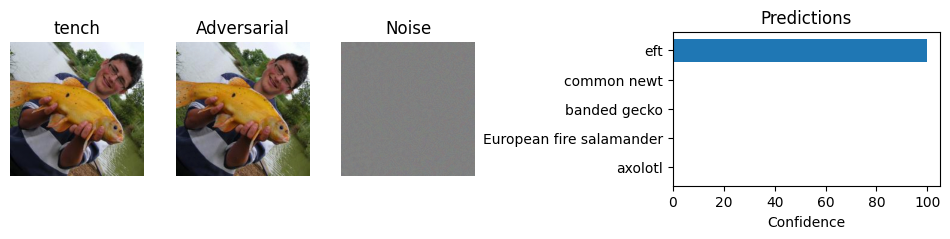

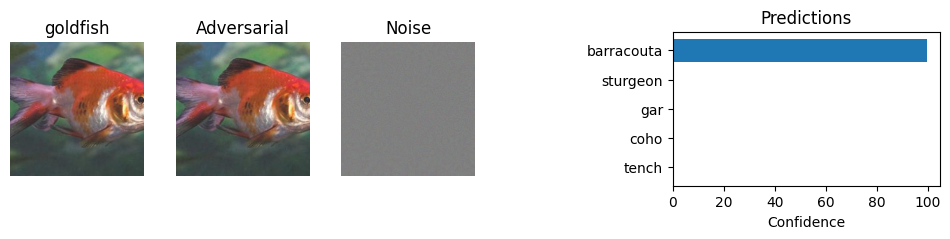

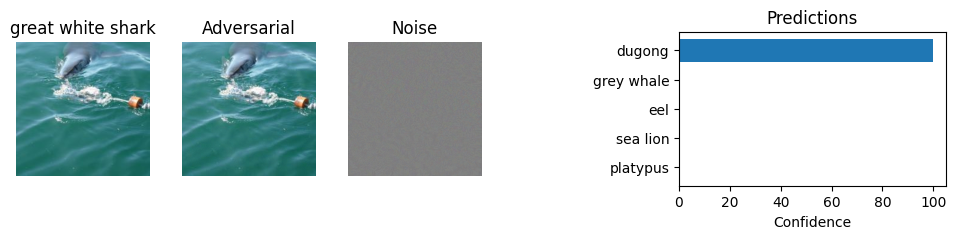

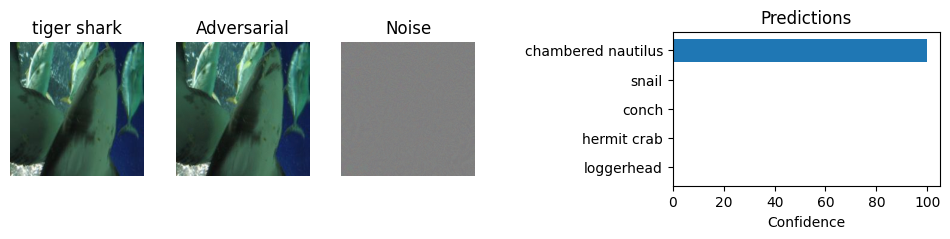

In [ ]:
adv_imgs, noise = projected_gradient_descent(pretrained_model, exmp_batch, label_batch, steps=10, alpha=2/255, epsilon=8/255)

with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i], norm=True)

In [16]:
_ = eval_model(data_loader, img_func=lambda x, y: projected_gradient_descent(pretrained_model, x, y, steps=10, alpha=2/255, epsilon=8/255)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error:  99.96%
Top-5 error:  93.28%


In [ ]:
def cw_loss(Z, delta, target_labels, c=0.5, loss_func=None):
    '''
    C&W 对抗样本损失函数

    参数:
        Z (Tensor): 模型最后一层 logits 输出
        delta (Tensor): 当前迭代的扰动张量
        target_labels (Tensor): 目标误分类标签
        c (float): 平衡系数
        loss_func (nn.Module): 扰动幅度计算方式(如L2范数)
    '''

    # TODO: 完成 C&W 损失函数代码

    

    # 示例占位代码，需替换
    loss = ...

    return loss

def cw_attack(model, imgs, target_labels, c=1, num_epoch=50, lr=1e-2):
    '''
    C&W 对抗样本生成函数

    参数:
        model (nn.Module): 目标模型(应处于评估模式)
        imgs (Tensor, device=cpu): 一个 epoch 的图像, 来自原始数据集
        target_labels (Tensor, device=cpu): 目标误分类标签
        c (int): 权衡常数
        num_epoch (int): C&W 扰动迭代次数
        lr (float): 优化器学习率
    '''
    
    
    # TODO: 完成C&W算法


    
    # 示例占位代码，需替换
    fake_imgs = imgs.clone() # 生成的对抗样本
    delta = torch.zeros_like(imgs) # 实际扰动
    
    return fake_imgs, delta # 需位于 cpu

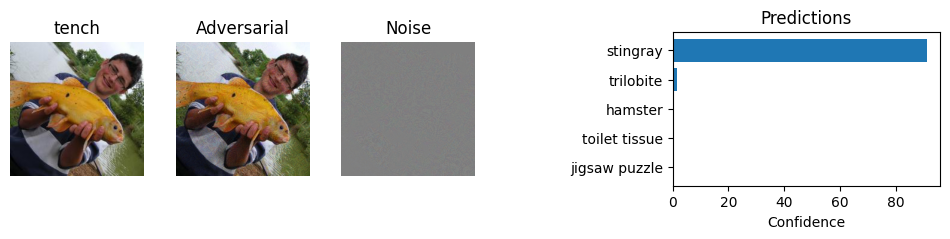

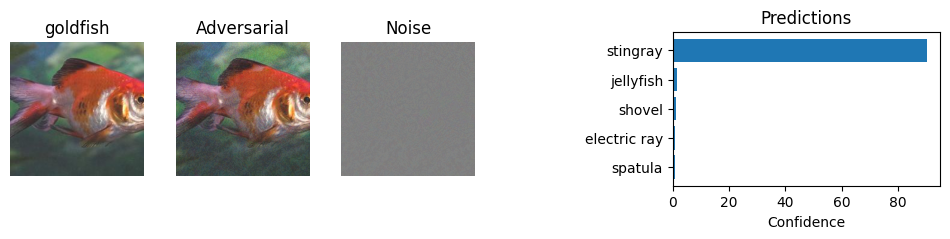

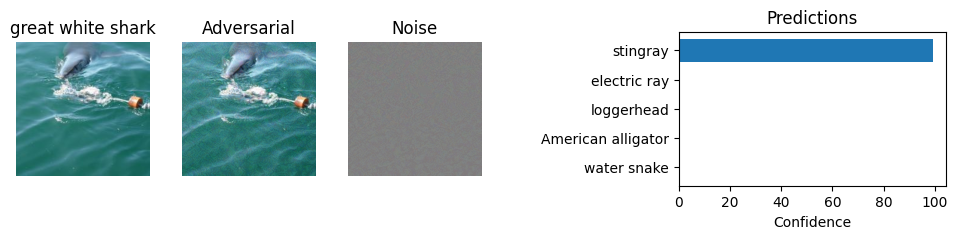

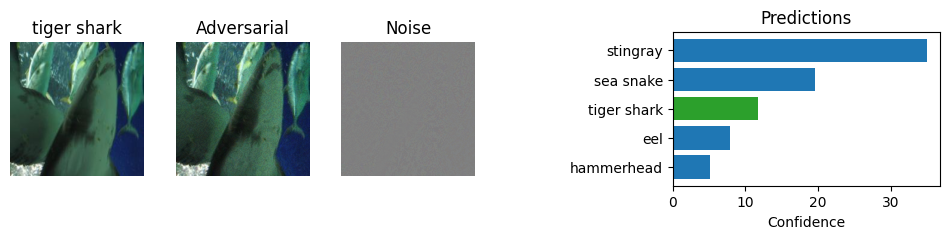

In [ ]:
# 由于cw攻击方法假定图像像素值均在[0,1]之间，因此这里不进行归一化(normalization)，而是直接将图像数据像素值转为[0,1]之间
no_norm_transforms = transforms.Compose([
    transforms.ToTensor(), # 图像数据转为tensor张量，且像素值放缩到[0, 1]范围
])
cw_dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=no_norm_transforms)
cw_data_loader = data.DataLoader(cw_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
cw_exmp_batch, cw_label_batch = next(iter(cw_data_loader))


# 随机选取 target_labels, 这里将所有 target_labels 都设为 6，可以根据喜好自定义 target_labels 以保证每个样本的 target_label 和原始 label 均不相同
target_labels = 5 + torch.ones_like(label_batch)
# 产生对抗样本和对应的噪声
adv_imgs, noise = cw_attack(pretrained_model, cw_exmp_batch, target_labels, c=1, num_epoch=50, lr=1e-2)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
for i in range(1, 17, 5):
    show_prediction(cw_exmp_batch[i], cw_label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise[i], norm=False)

In [44]:
_ = eval_model(dataset_loader=cw_data_loader, img_func=lambda x, y: cw_attack(pretrained_model, x, target_labels[0].expand(y.shape[0]), c=1, num_epoch=50, lr=1e-2)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error:  99.66%
Top-5 error:  93.66%
